In [ ]:
import torch
import matplotlib.pyplot as plt
import importlib
import training

importlib.reload(training)

from models import MLP, MLPVIB
from training import (
    getLoaders,
    getCorruptedLoaders,
    getDevice,
    evaluateWithNoise,
    trainRun,
    setSeed,
)


In [99]:
# Experiment 1 (clean training) – config
setSeed(0)
exp1_device = getDevice()
print(f"Device: {exp1_device}")

exp1_batch = 128
exp1_lr = 1e-3
exp1_epochs = 15
exp1_beta_vib = 1e-2
exp1_log_every = 5


Device: cpu


In [ ]:
# Experiment 1 – run
from torch import optim

exp1_train, exp1_test = getLoaders(batch=exp1_batch)

exp1_base = MLP().to(exp1_device)
exp1_vib = MLPVIB().to(exp1_device)

exp1_opt_base = optim.Adam(exp1_base.parameters(), lr=exp1_lr)
exp1_hist_base = trainRun(
    exp1_base,
    exp1_train,
    exp1_test,
    exp1_opt_base,
    exp1_device,
    exp1_epochs,
    beta=None,
    tag="EXP1-BASE",
    log_every=exp1_log_every,
)

exp1_opt_vib = optim.Adam(exp1_vib.parameters(), lr=exp1_lr)
exp1_hist_vib = trainRun(
    exp1_vib,
    exp1_train,
    exp1_test,
    exp1_opt_vib,
    exp1_device,
    exp1_epochs,
    beta=exp1_beta_vib,
    tag="EXP1-VIB",
    log_every=exp1_log_every,
)


[EXP1-BASE] Epoch 05: train loss=0.0444, CE=0.0444, KL=193.3452, train acc=0.9859, test loss=0.0804, test acc=0.9750
[EXP1-BASE] Epoch 10: train loss=0.0183, CE=0.0183, KL=315.3525, train acc=0.9941, test loss=0.0814, test acc=0.9781
[EXP1-BASE] Epoch 10: train loss=0.0183, CE=0.0183, KL=315.3525, train acc=0.9941, test loss=0.0814, test acc=0.9781
[EXP1-BASE] Epoch 15: train loss=0.0134, CE=0.0134, KL=399.2508, train acc=0.9953, test loss=0.0999, test acc=0.9800
[EXP1-BASE] Epoch 15: train loss=0.0134, CE=0.0134, KL=399.2508, train acc=0.9953, test loss=0.0999, test acc=0.9800
[EXP1-VIB] Epoch 05: train loss=0.2007, CE=0.0841, KL=11.6545, train acc=0.9774, test loss=0.0657, test acc=0.9812
[EXP1-VIB] Epoch 05: train loss=0.2007, CE=0.0841, KL=11.6545, train acc=0.9774, test loss=0.0657, test acc=0.9812
[EXP1-VIB] Epoch 10: train loss=0.1551, CE=0.0509, KL=10.4285, train acc=0.9862, test loss=0.0644, test acc=0.9820
[EXP1-VIB] Epoch 10: train loss=0.1551, CE=0.0509, KL=10.4285, train a

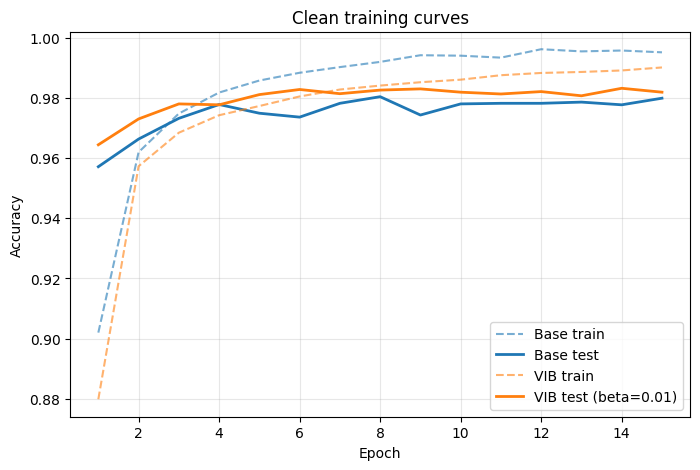

{'base_final_acc': 0.98, 'vib_final_acc': 0.982}

In [ ]:
# Experiment 1 – analysis
exp1_epochs_axis = range(1, exp1_epochs + 1)

plt.figure(figsize=(8, 5))
plt.plot(exp1_epochs_axis, exp1_hist_base["trainAcc"], "--", label="Base train", color="tab:blue", alpha=0.6)
plt.plot(exp1_epochs_axis, exp1_hist_base["testAcc"], "-", label="Base test", color="tab:blue", linewidth=2)
plt.plot(exp1_epochs_axis, exp1_hist_vib["trainAcc"], "--", label="VIB train", color="tab:orange", alpha=0.6)
plt.plot(exp1_epochs_axis, exp1_hist_vib["testAcc"], "-", label=f"VIB test (beta={exp1_beta_vib})", color="tab:orange", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Clean training curves")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

exp1_summary = {
    "base_final_acc": exp1_hist_base["testAcc"][-1],
    "vib_final_acc": exp1_hist_vib["testAcc"][-1],
}
exp1_summary


In [102]:
# Experiment 1b (clean train, noisy eval) – config
exp1b_sigmas = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.50]


In [ ]:
# Experiment 1b  – eval
exp1b_base_acc = [evaluateWithNoise(exp1_base, exp1_test, exp1_device, s) for s in exp1b_sigmas]
exp1b_vib_acc  = [evaluateWithNoise(exp1_vib,  exp1_test, exp1_device, s) for s in exp1b_sigmas]


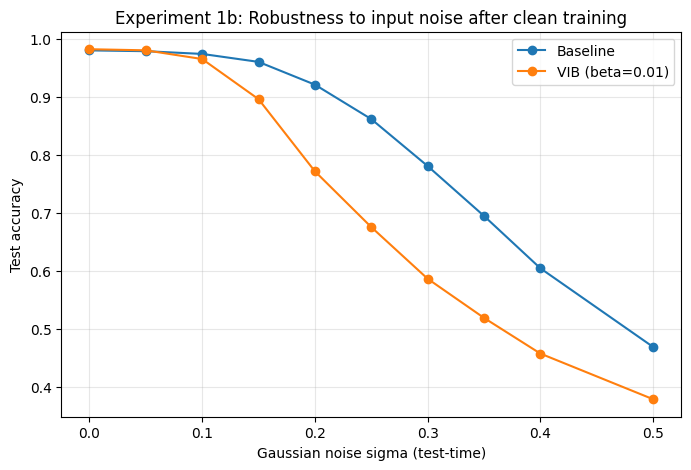

{'sigmas': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5],
 'baseAcc': [0.98,
  0.9786,
  0.9739,
  0.9602,
  0.921,
  0.8617,
  0.7809,
  0.695,
  0.6049,
  0.4695],
 'vibAcc': [0.982,
  0.9801,
  0.9651,
  0.896,
  0.7718,
  0.6758,
  0.5869,
  0.5195,
  0.4581,
  0.3795]}

In [ ]:
# Experiment 1b – analysis
plt.figure(figsize=(8, 5))
plt.plot(exp1b_sigmas, exp1b_base_acc, marker="o", label="Baseline")
plt.plot(exp1b_sigmas, exp1b_vib_acc, marker="o", label=f"VIB (beta={exp1_beta_vib})")
plt.xlabel("Gaussian noise sigma (test-time)")
plt.ylabel("Test accuracy")
plt.title("Experiment 1b: Robustness to input noise after clean training")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

exp1b_summary = {
    "sigmas": exp1b_sigmas,
    "baseAcc": exp1b_base_acc,
    "vibAcc": exp1b_vib_acc,
}
exp1b_summary


In [105]:
# Experiment 2 (noisy training) – config and helpers
import copy
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

class AddGaussianNoise:
    def __init__(self, sigma):
        self.sigma = sigma
    def __call__(self, x):
        if self.sigma <= 0:
            return x
        return torch.clamp(x + self.sigma * torch.randn_like(x), 0.0, 1.0)


def getLoadersNoiseTrain(train_sigma, batch=128, val_frac=0.1, seed=0):
    transform_train = transforms.Compose([transforms.ToTensor(), AddGaussianNoise(train_sigma)])
    transform_eval = transforms.ToTensor()

    full_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform_train)
    test = datasets.MNIST(root="./data", train=False, download=True, transform=transform_eval)

    n_total = len(full_train)
    n_val = int(val_frac * n_total)
    n_train = n_total - n_val

    g = torch.Generator().manual_seed(seed)
    train_ds, val_ds = random_split(full_train, [n_train, n_val], generator=g)

    trainLoad = DataLoader(train_ds, batch_size=batch, shuffle=True)
    valLoad = DataLoader(val_ds, batch_size=batch, shuffle=False)
    testLoad = DataLoader(test, batch_size=batch, shuffle=False)
    return trainLoad, valLoad, testLoad


def trainWithBestCheckpoint(model, trainLoad, valLoad, optimizer, device, numEpochs, beta=None):
    bestAcc = -1.0
    bestState = None
    history = {"valAcc": []}

    from training import oneEpoch, oneEpochVIB, evaluate

    for epoch in range(1, numEpochs + 1):
        if beta is None:
            trainLoss, trainCE, trainKL, trainAcc = oneEpoch(model, trainLoad, optimizer, device)
        else:
            trainLoss, trainCE, trainKL, trainAcc = oneEpochVIB(model, trainLoad, optimizer, device, beta)

        valLoss, valAcc = evaluate(model, valLoad, device)
        history["valAcc"].append(valAcc)

        if valAcc > bestAcc:
            bestAcc = valAcc
            bestState = copy.deepcopy(model.state_dict())

    model.load_state_dict(bestState)
    return history

exp2_device = exp1_device
exp2_seed = 0
exp2_batch = 128
exp2_lr = 1e-3
exp2_epochs = 30
exp2_beta_vib = 1e-2
exp2_train_sigma = 0.4
exp2_sigmas_eval = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8]


In [106]:
# Experiment 2 (noisy training) – run
from torch import optim

setSeed(exp2_seed)
trainLoad, valLoad, testLoad = getLoadersNoiseTrain(train_sigma=exp2_train_sigma, batch=exp2_batch, seed=exp2_seed)

exp2_base = MLP().to(exp2_device)
exp2_vib = MLPVIB().to(exp2_device)

exp2_opt_base = optim.Adam(exp2_base.parameters(), lr=exp2_lr)
exp2_hist_base = trainWithBestCheckpoint(exp2_base, trainLoad, valLoad, exp2_opt_base, exp2_device, exp2_epochs, beta=None)

exp2_opt_vib = optim.Adam(exp2_vib.parameters(), lr=exp2_lr)
exp2_hist_vib = trainWithBestCheckpoint(exp2_vib, trainLoad, valLoad, exp2_opt_vib, exp2_device, exp2_epochs, beta=exp2_beta_vib)

exp2_base_acc = [evaluateWithNoise(exp2_base, testLoad, exp2_device, s) for s in exp2_sigmas_eval]
exp2_vib_acc = [evaluateWithNoise(exp2_vib, testLoad, exp2_device, s) for s in exp2_sigmas_eval]


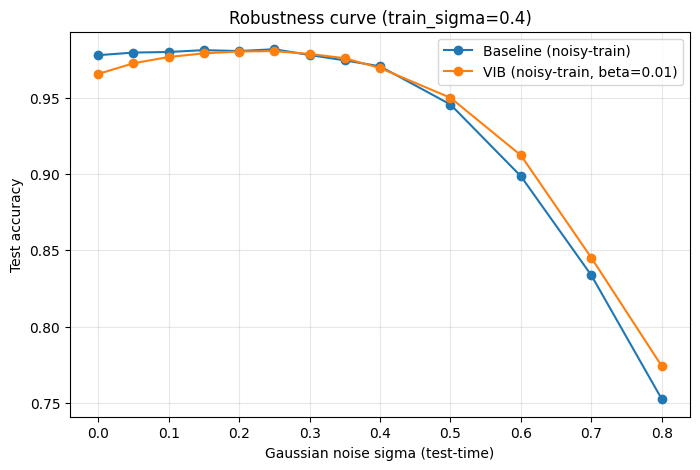

{'base_final_acc': 0.9778, 'vib_final_acc': 0.9655}

In [107]:
# Experiment 2 (noisy training) – analysis
plt.figure(figsize=(8, 5))
plt.plot(exp2_sigmas_eval, exp2_base_acc, marker="o", label="Baseline (noisy-train)", color="tab:blue")
plt.plot(exp2_sigmas_eval, exp2_vib_acc, marker="o", label=f"VIB (noisy-train, beta={exp2_beta_vib})", color="tab:orange")
plt.xlabel("Gaussian noise sigma (test-time)")
plt.ylabel("Test accuracy")
plt.title(f"Robustness curve (train_sigma={exp2_train_sigma})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

exp2_summary = {
    "base_final_acc": exp2_base_acc[0],
    "vib_final_acc": exp2_vib_acc[0],
}
exp2_summary


In [82]:
# Experiment 3 (label corruption) – config
from torch import optim

exp3_device = exp1_device
exp3_seed = 42
exp3_batch = 128
exp3_lr = 1e-3
exp3_epochs = 15
exp3_beta_vib = 1e-2
exp3_corruption_probs = [0.0, 0.2, 0.4, 0.6, 0.8]
exp3_target_corruption = 0.6
exp3_log_every = 5


In [ ]:
# Experiment 3 – run
setSeed(exp3_seed)

exp3_sweep_results = {
    "prob": exp3_corruption_probs,
    "base_test_acc": [],
    "vib_test_acc": [],
}
exp3_dynamics = {}

for prob in exp3_corruption_probs:
    print(f"\n=== STARTING RUN: Label Corruption Probability {prob} ===")

    trainLoad, testLoad = getCorruptedLoaders(corruption_prob=prob, batch=exp3_batch)

    print(f" >> Training Baseline (Prob={prob})...")
    exp3_base = MLP().to(exp3_device)
    exp3_base_opt = optim.Adam(exp3_base.parameters(), lr=exp3_lr)
    exp3_base_hist = trainRun(
        exp3_base,
        trainLoad,
        testLoad,
        exp3_base_opt,
        exp3_device,
        exp3_epochs,
        beta=None,
        tag=f"EXP3-BASE-{prob}",
        log_every=exp3_log_every,
    )
    exp3_sweep_results["base_test_acc"].append(exp3_base_hist["testAcc"][-1])

    print(f" >> Training VIB (Prob={prob})...")
    exp3_vib = MLPVIB().to(exp3_device)
    exp3_vib_opt = optim.Adam(exp3_vib.parameters(), lr=exp3_lr)
    exp3_vib_hist = trainRun(
        exp3_vib,
        trainLoad,
        testLoad,
        exp3_vib_opt,
        exp3_device,
        exp3_epochs,
        beta=exp3_beta_vib,
        tag=f"EXP3-VIB-{prob}",
        log_every=exp3_log_every,
    )
    exp3_sweep_results["vib_test_acc"].append(exp3_vib_hist["testAcc"][-1])

    if prob == exp3_target_corruption:
        exp3_dynamics["base"] = exp3_base_hist
        exp3_dynamics["vib"] = exp3_vib_hist

print("\n=== EXPERIMENT 3 COMPLETE===")



=== STARTING RUN: Label Corruption Probability 0.0 ===
 >> Training Baseline (Prob=0.0)...
[EXP3-BASE-0.0] Epoch 05: train loss=0.0442, CE=0.0442, KL=184.8028, train acc=0.9859, test loss=0.0867, test acc=0.9731
[EXP3-BASE-0.0] Epoch 05: train loss=0.0442, CE=0.0442, KL=184.8028, train acc=0.9859, test loss=0.0867, test acc=0.9731
[EXP3-BASE-0.0] Epoch 10: train loss=0.0146, CE=0.0146, KL=285.8219, train acc=0.9953, test loss=0.0899, test acc=0.9774
[EXP3-BASE-0.0] Epoch 10: train loss=0.0146, CE=0.0146, KL=285.8219, train acc=0.9953, test loss=0.0899, test acc=0.9774
[EXP3-BASE-0.0] Epoch 15: train loss=0.0096, CE=0.0096, KL=359.2414, train acc=0.9968, test loss=0.1003, test acc=0.9795
 >> Training VIB (Prob=0.0)...
[EXP3-BASE-0.0] Epoch 15: train loss=0.0096, CE=0.0096, KL=359.2414, train acc=0.9968, test loss=0.1003, test acc=0.9795
 >> Training VIB (Prob=0.0)...
[EXP3-VIB-0.0] Epoch 05: train loss=0.1964, CE=0.0803, KL=11.6069, train acc=0.9787, test loss=0.0644, test acc=0.9815
[

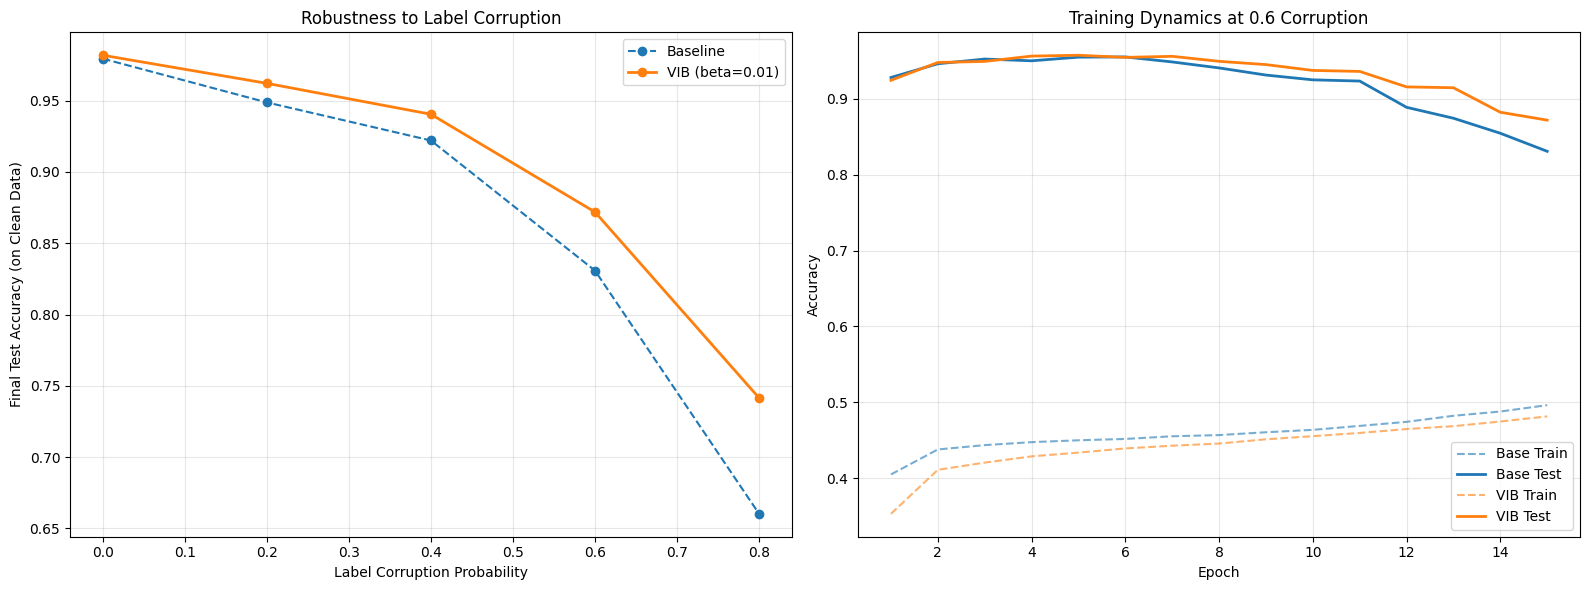

{'base_final_clean_acc': 0.6602, 'vib_final_clean_acc': 0.7415}

In [ ]:
# Experiment 3 – analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
ax.plot(exp3_sweep_results["prob"], exp3_sweep_results["base_test_acc"], "o--", label="Baseline", color="tab:blue")
ax.plot(exp3_sweep_results["prob"], exp3_sweep_results["vib_test_acc"], "o-", label=f"VIB (beta={exp3_beta_vib})", color="tab:orange", linewidth=2)
ax.set_title("Robustness to Label Corruption")
ax.set_xlabel("Label Corruption Probability")
ax.set_ylabel("Final Test Accuracy (on Clean Data)")
ax.grid(True, alpha=0.3)
ax.legend()

ax = axes[1]
exp3_epochs_axis = range(1, exp3_epochs + 1)
ax.plot(exp3_epochs_axis, exp3_dynamics["base"]["trainAcc"], "--", color="tab:blue", alpha=0.6, label="Base Train")
ax.plot(exp3_epochs_axis, exp3_dynamics["base"]["testAcc"], "-", color="tab:blue", linewidth=2, label="Base Test")
ax.plot(exp3_epochs_axis, exp3_dynamics["vib"]["trainAcc"], "--", color="tab:orange", alpha=0.6, label="VIB Train")
ax.plot(exp3_epochs_axis, exp3_dynamics["vib"]["testAcc"], "-", color="tab:orange", linewidth=2, label="VIB Test")
ax.set_title(f"Training Dynamics at {exp3_target_corruption} Corruption")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

exp3_summary = {
    "base_final_clean_acc": exp3_sweep_results["base_test_acc"][-1],
    "vib_final_clean_acc": exp3_sweep_results["vib_test_acc"][-1],
}
exp3_summary
